In [50]:
import random

In [51]:
random_seed = 10
random.seed(random_seed)

In [52]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

In [55]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df.head(5)

pk                                     source         internal_id  \
0   1  Roundtable on Sustainable Palm Oil (RSPO)  500Mg00000L0di6IAB   
1   2  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVwYqYAK   
2   3  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVxmPYAS   
3   4  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVGg2YAG   
4   5  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003vMwFgYAK   

                        status submitted_on accepted_on last_updated_on  \
0                       Closed    2/26/2025   4/15/2025       5/20/2025   
1  In Progress - Investigation   11/29/2024   1/16/2025       1/16/2025   
2  In Progress - Investigation   11/28/2024   1/21/2025       1/21/2025   
3  In Progress - Investigation   10/16/2024  11/18/2024      11/18/2024   
4  In Progress - Investigation    9/11/2024  10/29/2024      10/29/2024   

      country            region    complainants  \
0   Indonesia  Sumatera Selatan    Confidential   
1      Mexico               NaN    Confidential   
2    Colombia   Montes de María    Confidential   
3   Indonesia              Riau  S. Samsul Hadi   
4  Costa Rica      Pococi/Limón    Confidential   

                         respondents          respondent_sector  \
0             PT Sawit Mas Sejahtera           Oil Palm Growers   
1  INDUSTRIAS OLEOPALMA S.A. DE C.V.           Oil Palm Growers   
2                   OLEOFLORES S A S  Processors and/or Traders   
3              PT Guntung Idamannusa           Oil Palm Growers   
4           Compañía Palma Tica S.A.           Oil Palm Growers   

                           respondent_parent_company respondent_supplier  \
0                        Golden Agri-Resources (GAR)                 NaN   
1                  Oleoquímica Mexicana S.A. de C.V.                 NaN   
2                            Musim Mas Holdings Pte.                 NaN   
3  Compañía Industrial Aceitera Coto Cincuenta y ...                 NaN   
4                                                NaN                 NaN   

                                             summary  \
0  That the Respondent allegedly transferred the ...   
1  The Complainant alleges that the Respondent ha...   
2  1.The Complainant alleges that the Respondent ...   
3  The Respondent's Corporate Social Responsibili...   
4  The Complainant alleges that the Respondent br...   

                                             history  \
0  2025-05-20: CP's Decision Letter dated 20. 05....   
1  2025-04-30: The Secretariat furnished the Resp...   
2  2025-04-30: The Complaints Panels directive to...   
3  2025-04-30: The Complaints Panel has directed ...   
4  2025-04-30: The Briefing Note is in progress. ...   

                                       external_link  \
0  https://rspo.my.site.com/Complaint/s/case/500M...   
1  https://rspo.my.site.com/Complaint/s/case/500G...   
2  https://rspo.my.site.com/Complaint/s/case/500G...   
3  https://rspo.my.site.com/Complaint/s/case/500G...   
4  https://rspo.my.site.com/Complaint/s/case/500G...   

                                extras  
0   {'case_number': 'RSPO/2025/02/RR'}  
1  {'case_number': 'RSPO/2024/17/MAM'}  
2   {'case_number': 'RSPO/2024/18/HN'}  
3   {'case_number': 'RSPO/2024/14/RH'}  
4  {'case_number': 'RSPO/2024/13/MAM'}

## Preprocessing

In [56]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

## Embedding

In [57]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
        #adding this to see the shape of the embedding
        logging.info(f"Embedding shape for input: {emb.shape}")
        return emb
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

In [58]:
# embeddings are computed and saved in df
embedding_example = df.loc[df['embedding'].notnull(), 'embedding'].iloc[0]

print(type(embedding_example))  # we want a numpy array here
print(embedding_example.shape)  # This will tell us the embedding dimensions :)

<class 'numpy.ndarray'>
(384,)


## Model Creation

In [59]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [60]:
%pip install scikit-fuzzy

In [61]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [62]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=6, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [89]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize BERTopic model with a random_state for reproducibility

cluster_model = FuzzyCMeansModel(n_clusters= 6)
bertopic_model = BERTopic(hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, store the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

TypeError: BERTopic.__init__() got an unexpected keyword argument 'random_seed'

In [64]:
membership_df

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
0    0.005692  0.985799  0.003353  0.002231  0.001172  0.001753
1    0.003720  0.990837  0.002160  0.001426  0.000742  0.001116
2    0.759580  0.020099  0.142221  0.045188  0.010377  0.022535
3    0.140057  0.015068  0.654198  0.147610  0.012920  0.030147
4    0.450866  0.024896  0.331387  0.135381  0.018464  0.039007
..        ...       ...       ...       ...       ...       ...
382  0.564209  0.170133  0.138137  0.065678  0.021948  0.039896
383  0.058663  0.009002  0.797042  0.095696  0.011127  0.028470
384  0.033674  0.015179  0.061250  0.067242  0.619010  0.203646
385  0.051681  0.023976  0.092932  0.106131  0.492127  0.233153
386  0.062174  0.029210  0.111350  0.130229  0.426211  0.240826

[387 rows x 6 columns]

In [65]:
df_embeddings['probs']

0      0.985799
1      0.990837
2      0.759580
3      0.654198
4      0.450866
         ...   
382    0.564209
383    0.797042
384    0.619010
385    0.492127
386    0.426211
Name: probs, Length: 387, dtype: float64

In [66]:
print(bertopic_model.get_topic_info())

   Topic  Count                               Name  \
0      0    102   0_land_communities_hcv_complaint   
1      1     81            1_ha_earth_mighty_rapid   
2      2     58          2_eof_forest_mill_illegal   
3      3     53  3_workers_labour_union_employment   
4      4     50    4_river_sustainable_waste_water   
5      5     43   5_deforestation_gar_linked_chain   

                                      Representation  \
0  [land, communities, hcv, complaint, complainan...   
1  [ha, earth, mighty, rapid, response, concessio...   
2  [eof, forest, mill, illegal, gar, plantation, ...   
3  [workers, labour, union, employment, rights, c...   
4  [river, sustainable, waste, water, use, indone...   
5  [deforestation, gar, linked, chain, jaya, supp...   

                                 Representative_Docs  
0  [points raised npp published challenging time ...  
1  [mighty earth rapid response 14 april total fo...  
2  [may june 2021 eyes forest eof published title...  
3  [unau

## Raw Output

In [67]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['land', 'communities', 'hcv', 'complaint', 'complainants', 'local', 'allegations', 'customary', 'new', 'planting']
Topic 1 Representation: ['ha', 'earth', 'mighty', 'rapid', 'response', 'concession', 'deforestation', 'indications', 'forest', 'clearance']
Topic 2 Representation: ['eof', 'forest', 'mill', 'illegal', 'gar', 'plantation', 'plantations', 'bukit', 'ffb', 'supplier']
Topic 3 Representation: ['workers', 'labour', 'union', 'employment', 'rights', 'casual', 'daily', 'working', 'bpjs', 'termination']
Topic 4 Representation: ['river', 'sustainable', 'waste', 'water', 'use', 'indonesia', 'plantation', 'forest', 'local', 'fire']
Topic 5 Representation: ['deforestation', 'gar', 'linked', 'chain', 'jaya', 'supply', 'mighty', 'earth', 'rapid', 'response']


In [68]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [69]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [70]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {f"Topic_{i}_Perc": 0.0 for i in range(n_topics)}
        topic_binary = {f"Topic_{i}_Indicate": 0 for i in range(n_topics)}

        shared_perc = 0.0
        dom_topic_num = dominant_topic if dominant_topic != -1 else None
        dom_topic_prob = topic_prob
        is_outlier = (dominant_topic == -1)
        itr = 0

        # Simulate topic breakdown via probability — if available
        if not is_outlier and isinstance(topic_prob, float):
            # Use the membership probabilities from the row if available
            for i in range(n_topics):
                topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'] * 100, 2)
                if row[f'Topic_{i}'] > 0: # Indicate if there's any contribution
                    topic_binary[f"Topic_{i}_Indicate"] = 1

            shared_perc = topic_dist[f"Topic_{dominant_topic}_Perc"]
            dom_topic_num = dominant_topic
            itr = sum(list(topic_binary.values())) # Count number of topics with contribution
        else:
            # Optionally apply fallback logic for topic proportion
            topic_dist[f"Topic_{dominant_topic}_Perc"] = 100.0
            topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
            dom_topic_num = dominant_topic
            itr = 1

        # Keywords
        if dom_topic_num is not None and dom_topic_num != -1:
            keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])
        else:
            keywords = "Outlier Topic"

        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [71]:
df_embeddings

pk                                     source         internal_id  \
0      1  Roundtable on Sustainable Palm Oil (RSPO)  500Mg00000L0di6IAB   
1      2  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVwYqYAK   
2      3  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVxmPYAS   
3      4  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVGg2YAG   
4      5  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003vMwFgYAK   
..   ...                                        ...                 ...   
382  422                       Wilmar International                 NaN   
383  423                       Wilmar International                 NaN   
384  426                       Wilmar International                 NaN   
385  429                       Wilmar International                 NaN   
386  430                       Wilmar International                 NaN   

                          status submitted_on accepted_on last_updated_on  \
0                         Closed    2/26/2025   4/15/2025       5/20/2025   
1    In Progress - Investigation   11/29/2024   1/16/2025       1/16/2025   
2    In Progress - Investigation   11/28/2024   1/21/2025       1/21/2025   
3    In Progress - Investigation   10/16/2024  11/18/2024      11/18/2024   
4    In Progress - Investigation    9/11/2024  10/29/2024      10/29/2024   
..                           ...          ...         ...             ...   
382                       Closed    2/25/2015         NaN             NaN   
383                       Closed    12/8/2015         NaN             NaN   
384                       Closed    8/19/2015         NaN             NaN   
385                       Closed     6/5/2015         NaN             NaN   
386                       Closed    6/11/2014         NaN             NaN   

        country            region                complainants  ...  \
0     Indonesia  Sumatera Selatan                Confidential  ...   
1        Mexico               NaN                Confidential  ...   
2      Colombia   Montes de María                Confidential  ...   
3     Indonesia              Riau              S. Samsul Hadi  ...   
4    Costa Rica      Pococi/Limón                Confidential  ...   
..          ...               ...                         ...  ...   
382         NaN               NaN  Friends of the Earth (FoE)  ...   
383         NaN               NaN  Friends of the Earth (FoE)  ...   
384         NaN               NaN        Greenomics Indonesia  ...   
385         NaN               NaN        Greenomics Indonesia  ...   
386         NaN               NaN        Greenomics Indonesia  ...   

    bertopic_topic bertopic_prob   Topic_0   Topic_1   Topic_2   Topic_3  \
0                3          None  0.005692  0.985799  0.003353  0.002231   
1                3          None  0.003720  0.990837  0.002160  0.001426   
2                0          None  0.759580  0.020099  0.142221  0.045188   
3                4          None  0.140057  0.015068  0.654198  0.147610   
4                0          None  0.450866  0.024896  0.331387  0.135381   
..             ...           ...       ...       ...       ...       ...   
382              0          None  0.564209  0.170133  0.138137  0.065678   
383              4          None  0.058663  0.009002  0.797042  0.095696   
384              1          None  0.033674  0.015179  0.061250  0.067242   
385              1          None  0.051681  0.023976  0.092932  0.106131   
386              1          None  0.062174  0.029210  0.111350  0.130229   

      Topic_4   Topic_5 topic     probs  
0    0.001172  0.001753     1  0.985799  
1    0.000742  0.001116     1  0.990837  
2    0.010377  0.022535     0  0.759580  
3    0.012920  0.030147     2  0.654198  
4    0.018464  0.039007     0  0.450866  
..        ...       ...   ...       ...  
382  0.021948  0.039896     0  0.564209  
383  0.011127  0.028470     2  0.797042  
384  0.619010  0.203646     4  0.619010  
385  0

In [72]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)


dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)

## Data Exploration

In [73]:
#sorting by % topic contribution for readability
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 0].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
116           116               0         0.949420   
19             19               0         0.938899   
127           127               0         0.934236   
220           220               0         0.928019   
169           169               0         0.909716   
..            ...             ...              ...   
381           381               0         0.401844   
364           364               0         0.398938   
343           343               0         0.387294   
166           166               0         0.364414   
133           133               0         0.356454   

                                        Topic_Keywords  \
116  land, communities, hcv, complaint, complainant...   
19   land, communities, hcv, complaint, complainant...   
127  land, communities, hcv, complaint, complainant...   
220  land, communities, hcv, complaint, complainant...   
169  land, communities, hcv, complaint, complainant...   
..                                                 ...   
381  land, communities, hcv, complaint, complainant...   
364  land, communities, hcv, complaint, complainant...   
343  land, communities, hcv, complaint, complainant...   
166  land, communities, hcv, complaint, complainant...   
133  land, communities, hcv, complaint, complainant...   

                                                  Text  Is_Outlier  \
116  1 violation principle 2 2 persistence claim su...       False   
19   conducted land clearing outside boundaries hak...       False   
127  nagari kapa long demanded clarity extent php 1...       False   
220    complaint damaged road sumber indah perkasa sip       False   
169  desa pergulaan disputing legitimacy land acqui...       False   
..                                                 ...         ...   
381  bidco uganda limited joint venture wilmar 48 s...       False   
364  allegations land rights labour rights violatio...       False   
343  land rights labour rights violations environme...       False   
166  failed carry hcv assessment prior land clearin...       False   
133  rspos code conduct members members expected pr...       False   

     Dom_Topics_Num  Topic_0_Perc  Topic_1_Perc  Topic_2_Perc  Topic_3_Perc  \
116               6         94.94          0.69          2.64          1.06   
19                6         93.89          0.60          3.53          1.16   
127               6         93.42          0.64          3.67          1.45   
220               6         92.80          0.88          3.82          1.55   
169               6         90.97          1.35          4.47          1.97   
..              ...           ...           ...           ...           ...   
381               6         40.18         24.74         17.76          8.42   
364               6         39.89         32.21         13.70          7.00   
343               6         38.73         33.61         13.52          6.94   
166               6         36.44          2.68         34.66         20.17   
133               6         35.65          2.81         33.46         21.87   

     Topic_4_Perc  Topic_5_Perc  Topic_0_Indicate  Topic_1_Indicate  \
116          0.23          0.44                 1                 1   
19           0.26          0.55                 1                 1   
127          0.28          0.54                 1                 1   
220          0.32          0.62                 1                 1   
169          0.43          0.81                 1                 1   
..            ...           ...               ...               ...   
381          3.17          5.72                 1                 1   
364          2.61          4.60                 1                 1   
343          2.61          4.60                 1                 1   
166          2.02          4.03                 1                 1   
133          2.09          4.12                 1                 1   

     Topic_2_Ind

In [74]:
#df_embeddings[df_embeddings['topic'] == 0]

In [75]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 1].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
36             36               1         0.992183   
1               1               1         0.990837   
205           205               1         0.989750   
120           120               1         0.988688   
62             62               1         0.986492   
24             24               1         0.985881   
0               0               1         0.985799   
43             43               1         0.984334   
18             18               1         0.983564   
23             23               1         0.982892   
22             22               1         0.981919   
297           297               1         0.981309   
92             92               1         0.978008   
9               9               1         0.977604   
17             17               1         0.977446   
66             66               1         0.977399   
79             79               1         0.976802   
45             45               1         0.975187   
41             41               1         0.973110   
98             98               1         0.970300   
33             33               1         0.964836   
90             90               1         0.961842   
65             65               1         0.961276   
64             64               1         0.960578   
96             96               1         0.956593   
58             58               1         0.953761   
72             72               1         0.951400   
60             60               1         0.947726   
5               5               1         0.945979   
21             21               1         0.945073   
39             39               1         0.943030   
48             48               1         0.936793   
54             54               1         0.936305   
235           235               1         0.933649   
71             71               1         0.929611   
67             67               1         0.919331   
78             78               1         0.918223   
207           207               1         0.889490   
206           206               1         0.704720   
288           288               1         0.684992   
376           376               1         0.683076   
353           353               1         0.675594   
359           359               1         0.656691   
367           367               1         0.652981   
290           290               1         0.643647   
351           351               1         0.639925   
366           366               1         0.637164   
348           348               1         0.631539   
289           289               1         0.631395   
281           281               1         0.569684   
362           362               1         0.464041   
369           369               1         0.410816   
8               8               1         0.404441   

                                        Topic_Keywords  \
36   workers, labour, union, employment, rights, ca...   
1    workers, labour, union, employment, rights, ca...   
205  workers, labour, union, employment, rights, ca...   
120  workers, labour, union, employment, rights, ca...   
62   workers, labour, union, employment, rights, ca...   
24   workers, labour, union, employment, rights, ca...   
0    workers, labour, union, employment, rights, ca...   
43   workers, labour, union, employment, rights, ca...   
18   workers, labour, union, employment, rights, ca...   
23   workers, labour, union, employment, rights, ca...   
22   workers, labour, union, employment, rights, ca...   
297  workers, labour, union, employment, rights, ca...   
92   workers, labour, union, employment, rights, ca...   
9    workers, labour, union, employment, rights, ca...   
17   workers, labour, union, employment, rights, ca...   
66   workers, labour, union, employment, rights, ca...   
79   workers, labour, union, employment, rights, ca...   
45   workers, labour, union, employment, rig

## Wordcloud

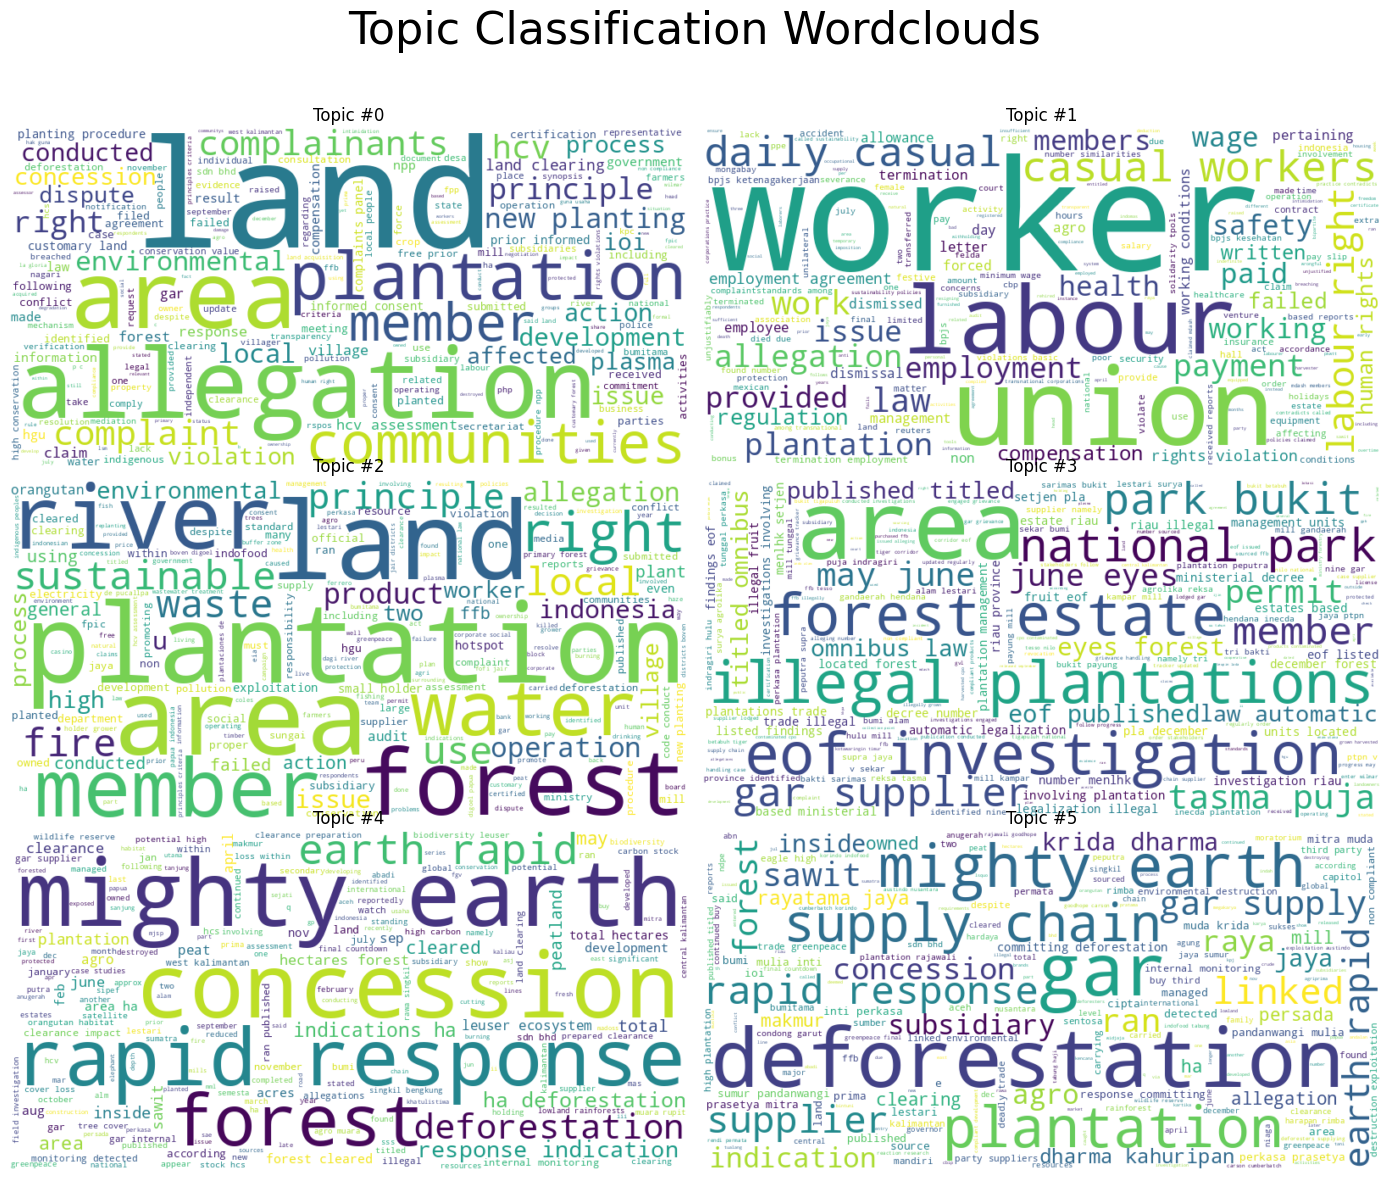

In [76]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds', n_topics=6)

## Dominant Topic Frequency

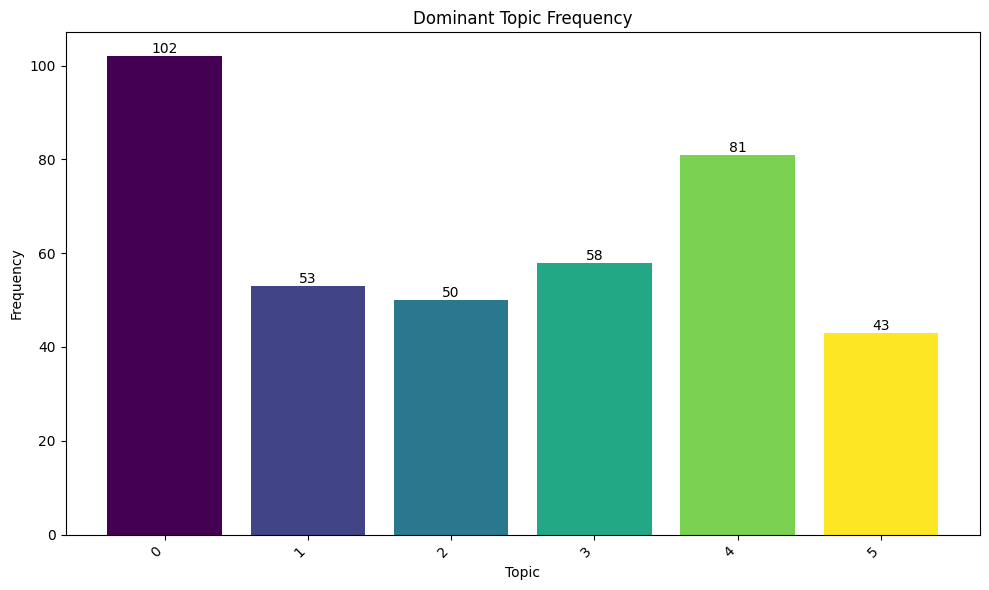

In [77]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure dominant_topic_df is available
if  'dominant_topic_df' not in locals():
    print("Error:  dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    #https://colab.research.google.com/drive/1jQiYlqZ7jpm4bk9UP0JvYhVLkcXenWPF?authuser=1#scrollTo=Overall_Dominant_Topic_Share
    # Calculate topic share (frequency) from dominant_topic_df
    df_topic_share = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    # df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Topic Distribution per Doc

In [78]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

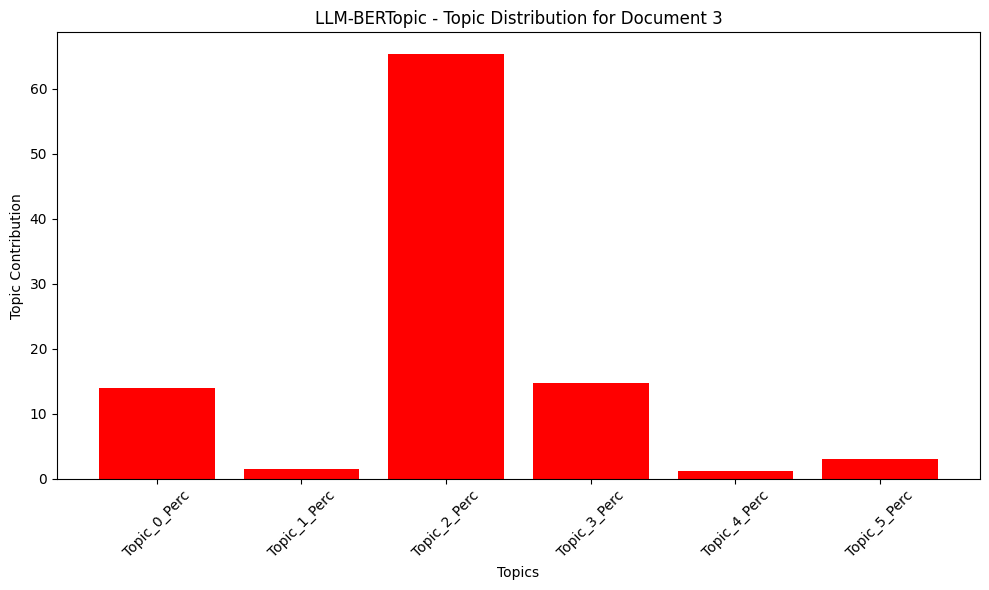

In [79]:
doc_number = 3    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Overall Dominant Topic % Share

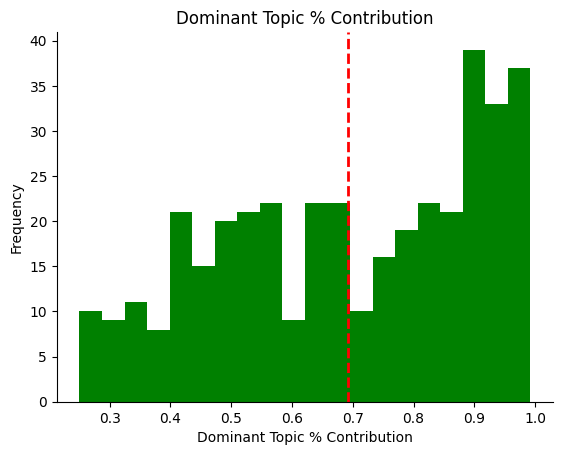

In [80]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)

    # Add Mean line
    mean_value = dominant_topic_df['Topic_%_Contrib'].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Scoring Methods

## Topic Coherence Score

In [81]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


Topic Coherence: 0.6471662248391317


## Topic Diversity

In [82]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.8333333333333334


## Silhouette Score

In [83]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.040007725


## Davies-Bouldin Index

In [84]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 3.968532652166337


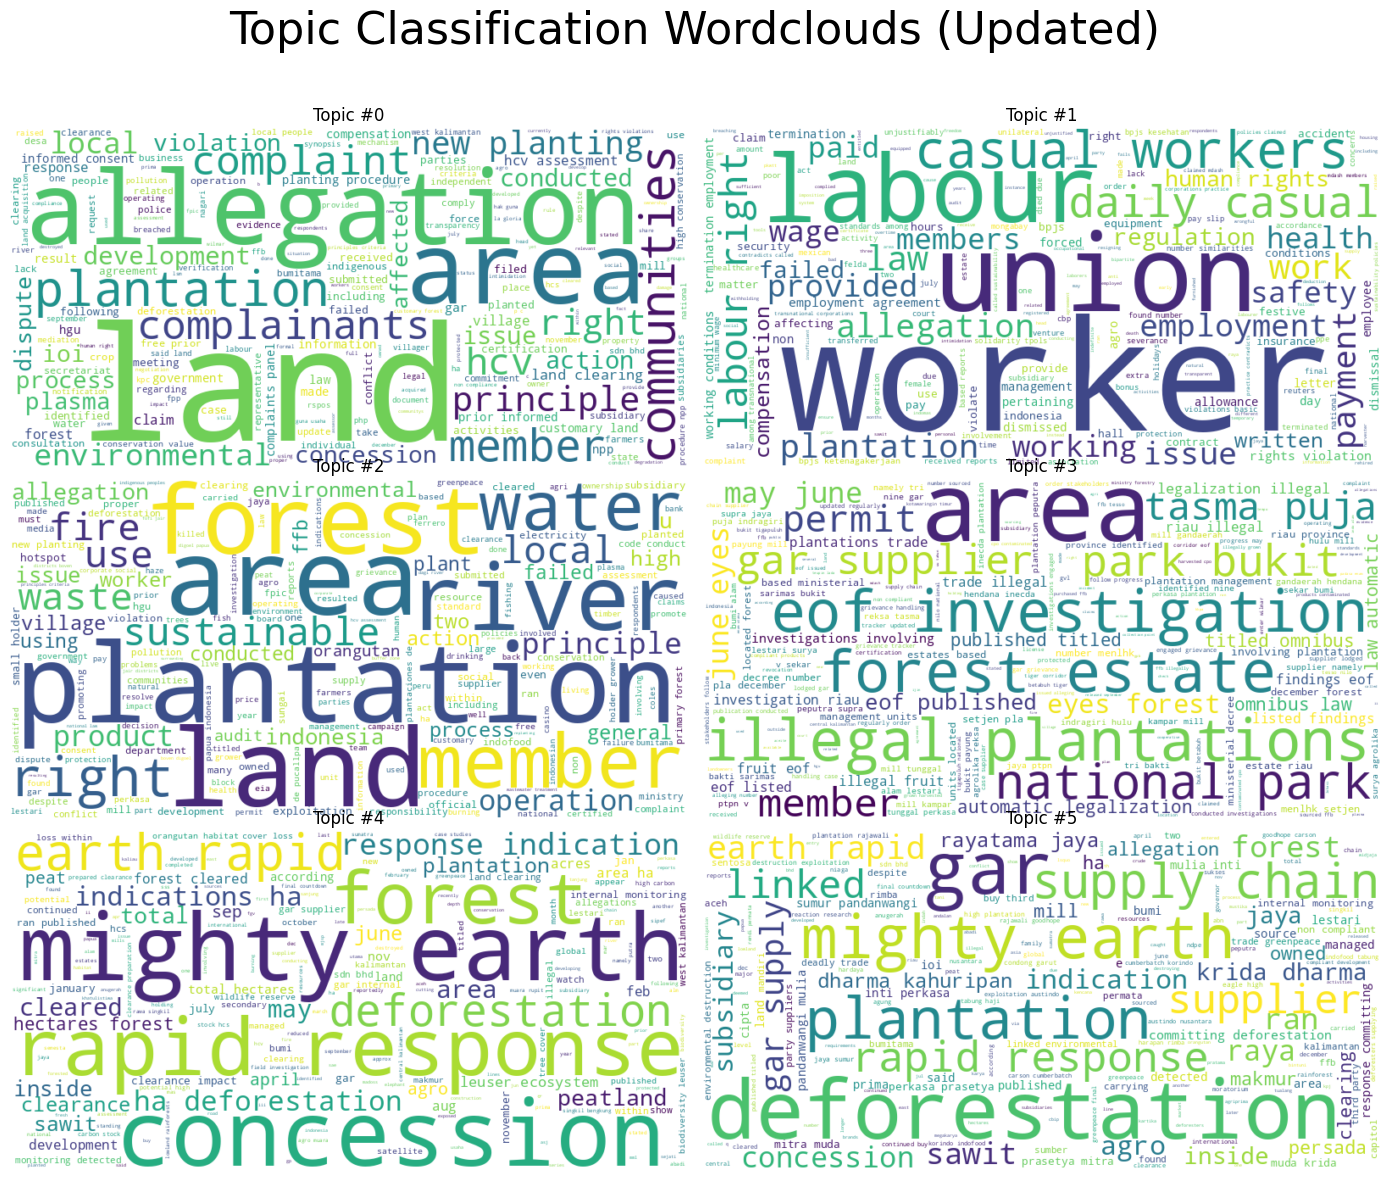

In [85]:
dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds (Updated)', n_topics=number_of_topics)

In [86]:
bertopic_model.visualize_hierarchy()

In [87]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 5/5 [00:00<00:00, 233.45it/s]


In [88]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)


In [91]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(df_embeddings)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)

ValueError: could not convert string to float: 'Roundtable on Sustainable Palm Oil (RSPO)'